In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# TD Control (Model-free Control)

So far, we assumed that the agent has full knowledge of the Markov Decision Process. However, this is usually not the case. 

Here, we look at __mode-free control__, that is, the agent does not have access to the dynamcis of the system but can just execute actions and observer rewards to slowly build the value function for the enviornment.

Here, we implement the grid world example with wind (perturbations) from the RL Lecture 5 by Davin Silver for model-free control [see example](https://youtu.be/0g4j2k_Ggc4?t=3174)

We use TD policy evaluation based on the action-value function $Q=q_\pi$ and then a $\epsilon$-greedy exploration (greedy exploration with probability to choose a random move).


__SARSA Algorithm for On-Policy Control__
* Initialize $Q(s,a)$ arbitrarily (can be zero for example). $Q(terminal-state,\cdot) = 0$
* Repeat (for each episode):
    * Initialize $S$
    * Choose $A$ from $S$ using policy derived from $\epsilon$-greedy
    * Repeat (for each step of episode):
        * Take action $A$, observer $R$, $S'$
        * Choose $A'$ from $S'$ using policy derived from $\epsilon$-greedy
        * $Q(S,A) \gets Q(S,A) + \alpha \left [ R + \gamma Q(S',A') - Q(S,A) \right]$
        * $S \gets S'$ , $A \gets A'$
    * until $S$ is terminal state

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotting
import random
from operator import itemgetter

plotting.set_layout(drawing_size=15)


## Define the Environment

* In every state (except goal state) a moment has a cost of -1
* In a goal state, thers is no cost for moving
* If the agent is in a goal state, do not execute any moevement


In [260]:

class environment():
    """ This class defines all the necessary properties of the environment. 
        For now, the environment is a nxn rectangular grid"""
    
    def __init__(self,n_x=10,n_y=7,s_start=(0,3),s_goals=[(7,3)]):
        """ n_x: defines the width of the environment
            n_y: defines the height of the environment
            s_start: defines the starting position of the agent (x-,y-position)
            """ 
        
        # Define the grid
        self.n_x = n_x
        self.n_y = n_y
        
        
        # Agent position
        self.x_agent = s_start[0]
        self.y_agent = s_start[1]
        # Agent actions
        self.actions = [0,1,2,3] # equals 'n','e','s','w'
        
        # Define rewards
        self.rewards = np.ones((n_x,n_y)) * (-1)
        # Define goal states
        self.s_goals = s_goals
        for g_i,g in enumerate(s_goals):
            self.rewards[g] = 0
            
        # Define the perturbations (wind)
        # first tuple entry gives the x location. second entry the strength at that location
        self.wind = [(3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1)]
            
    
    def reset_agent(self, s_start):
        # Resets the the agent's position to the original starting position
        self.x_agent = s_start[0]
        self.y_agent = s_start[1]
            
    
    
    def move(self,a=None,state=None):
        """ Moves the agent from its current state to the next state given action a
            and returns a reward for that movement and the new state
            a: is the action            
        """

        assert(a in self.actions)
        
       
        x = self.x_agent
        y = self.y_agent
              
        # execute movement. For now, the environment is deterministic
        if a == 0:
            x += 1
        if a == 1:
            x -= 1
        if a == 2:
            y -= 1
        if a == 3:
            y += 1
            
        # Simulate the perturbations (wind in y-direction)
        # For now they are fixed as shown in the lecture 
        # check if the agent is on a windy spot
        if x in [i[0] for i in self.wind]:
            # move the agent in the direction (upwards is negative)
            y -= [i[1] for i in self.wind if x==i[0]][0]
                
        
        # If agent is in a goal state, do not move anymore and end the episde
        if (x, y) in self.s_goals:
            return x,y,self.get_reward(x,y),True
        
        
        # make sure to stay in the environment. if an acion moves the agent outside, just remain in current state
        x = max(min(x,self.n_x-1),0)
        y = max(min(y,self.n_y-1),0)
        
        # set new state and return rewards of new state
        self.x_agent = x
        self.y_agent = y
        return x,y, self.get_reward(x,y), False
    
    def get_reward(self, x,y):
        # Returns the reward for a given state
        return self.rewards[x,y]
        

## Define the Agent

In [261]:

class agents():
    """ This class defines the agent 
    """
    
    def __init__(self,n_x=10,n_y=7,pos_start=(0,3),epsilon=1.0):
        """ n_x: defines the width of the environment
            n_y: defones the height of the environment
            pos_start: defines the starting position of the agent (x-,y-position)
            gamma: the discount factor            """ 
        
        
        # Store the discount factor 
        self.gamma = 1
        # Store the update rate
        self.alpha = 0.5
        # Store the epsilon paramter
        self.epsilon = epsilon

        
        # Store size of environment
        self.n_x = n_x
        self.n_y = n_y
                
        # Agent actions
        self.actions = [0,1,2,3] # equals 'n','e','s','w'
        
        # Store the action value function for each state and action
        self.q = np.zeros((n_x,n_y,len(self.actions)))
        
    def set_epsilon(self,epsilon):
        # set the epsilon parameter
        # Needed to turn off epsilon greedy behavior
        self.epsilon = epsilon

    def greedy_move(self,s, k_episode):
        # given a state return the next move according to epsilon greedy algorithm
        
        # find optimal action a^*
        q_a = []
        for i_a,a in enumerate(self.actions):
            # get value for action state pair
            v = self.q[s[0],s[1],a]
            q_a.append((v,a))
    
        # get action with maximal value
        a_max = max(q_a,key=itemgetter(0))[1]
        
        # with probabiliyt 1-eps execute the best action otherwise choose other action
        if np.random.rand() <= (1-self.epsilon):
            a = a_max
        else:
            # choose an action randomly
            a = random.sample(self.actions,1)[0]
        
        # decrement epsilon
        if self.epsilon != 0.0:
            self.epsilon = 1/(k_episode)
        
        return a
                          
    
    def policy_evaluation(self,state, reward, action, new_state, new_action):
        # Update Q(s,a) incrementally 

        # Get the action-value function for that state
        Q_s = self.q[state[0],state[1],action]
        
        # choose the next action and state using the policy derived from e-greedy
        # Update the value funtion
        self.q[state[0],state[1],action] = Q_s + self.alpha * (reward + self.gamma * self.q[new_state[0],new_state[1], new_action] -  Q_s )

In [268]:
# Set up the environmental variables

# environment size
n_x = 10
n_y = 7

# start position of agent
start_state = [0,3]

# initialize everything
env = environment(n_x=n_x, n_y=n_y, s_start=start_state)
agent = agents(n_x=n_x, n_y=n_y, pos_start=start_state)

# number of episodes to run
k = 170

# counts the needed time steps to reach the goal per episode
ts_per_episode = np.zeros(k)

# run for k epsiodes:
for ep in range(k):
    # set the agent back to the starting position
    env.reset_agent(start_state)
    goal_reached = False
    # reset counter
    i = 0
    # set the initial state
    s = start_state
    # choose initial action of the agent
    a = agent.greedy_move(s,1)
    # run the policy iteration until goal is reached
    while not goal_reached:
        # execute movement
        x,y,reward, goal_reached = env.move(a)
        
        # set s'
        s_prime = [x,y]
        
        # choose the next move a' according to e-greedy
        a_prime = agent.greedy_move(s_prime,i+1)

        # do TD learning based on states, actions and rewards
        agent.policy_evaluation(s,reward,a,s_prime,a_prime)

        # set new states and actions
        s = s_prime
        a = a_prime
        i += 1
        
    # save the neede time steps
    ts_per_episode[ep] = i        
    

    


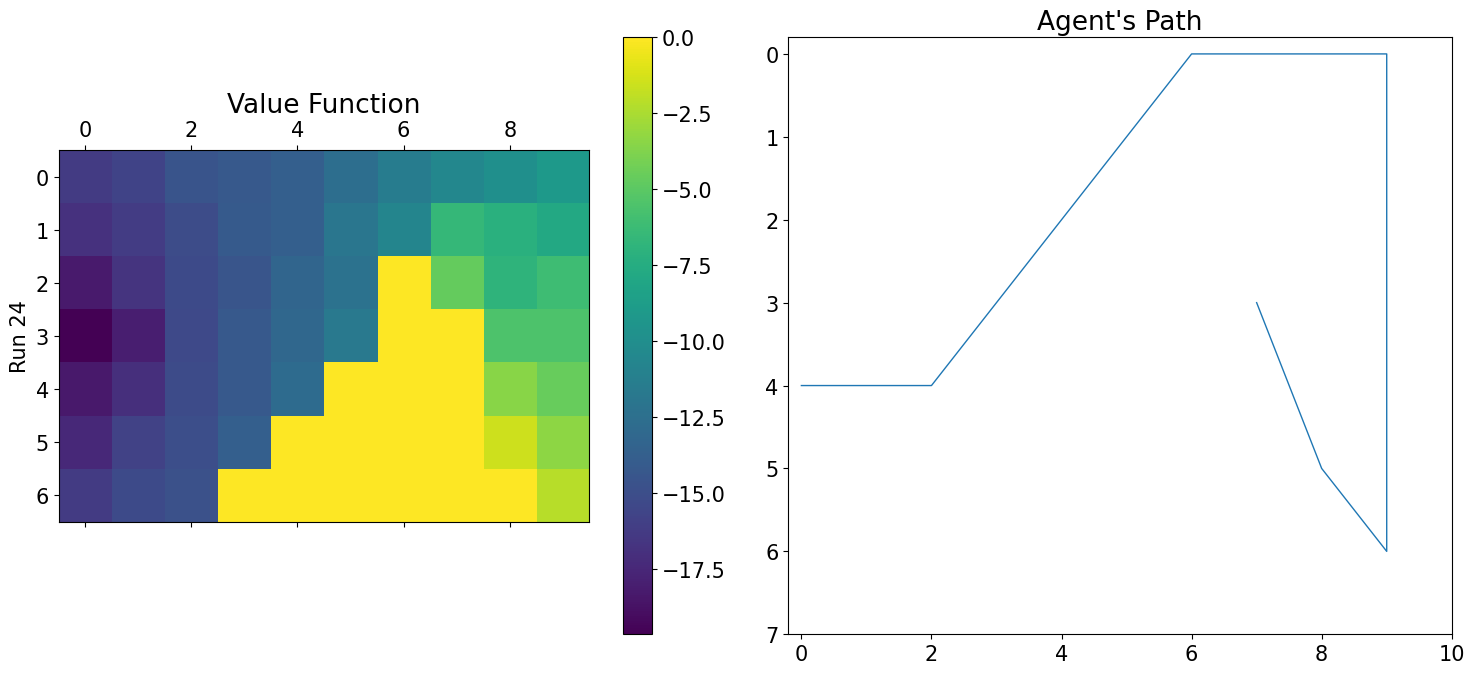

In [269]:
# plot the results
fig =plt.figure(figsize=(15,7))
axes = fig.subplots(1,2,squeeze=False)
ax = axes[0,0]
c = ax.matshow(agent.q.mean(2).T)
ax.set_ylabel('Run {0:}'.format(i))
ax.set_title('Value Function')
plt.colorbar(c, ax = ax)




#### Plot best policy

ax = axes[0,1]
env_ = environment(n_x=n_x, n_y=n_y, s_start=start_state)
# set epsilon to zero so that we follow a greedy policy
agent.set_epsilon(0.0)

goal_reached = False

x_s =[]
y_s =[]

s = start_state
while not goal_reached:
    a = agent.greedy_move(s,1)
    x,y,reward, goal_reached = env_.move(a)
    x_s.append(x)
    y_s.append(y)
    s = [x,y]

    
ax.plot(x_s,y_s)

ax.set_xlim(-0.2,n_x)
ax.set_ylim(-0.2,n_y)
ax.invert_yaxis()
ax.set_title('Agent\'s Path')
plt.tight_layout()
plt.show()





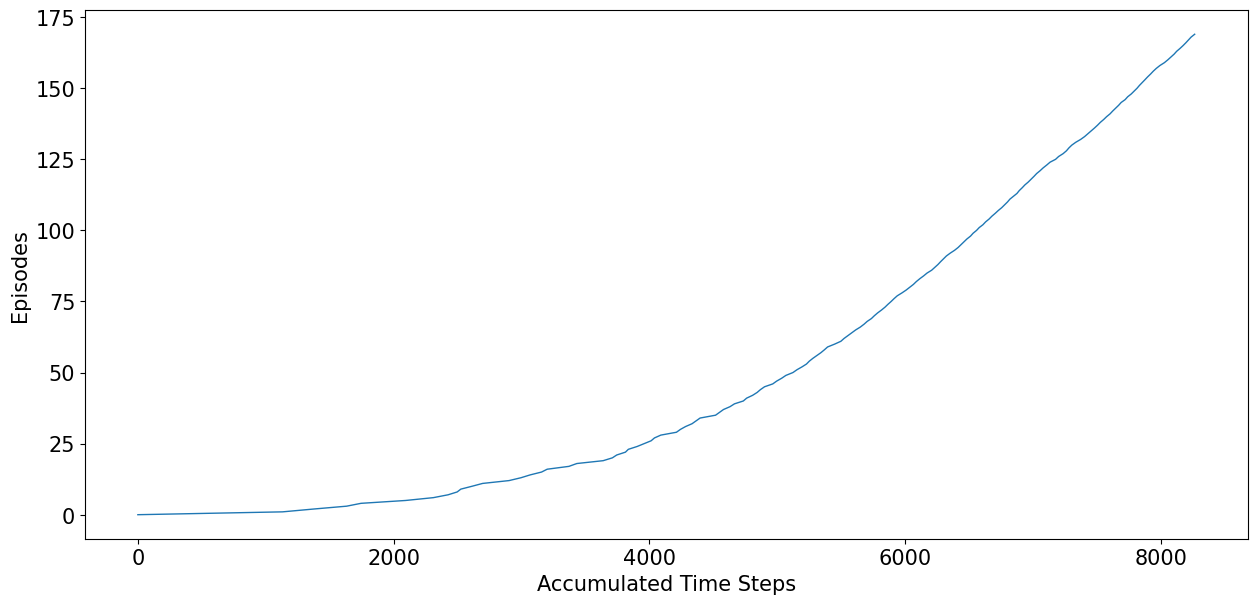

In [270]:
# plot the results
fig =plt.figure(figsize=(15,7))
axes = fig.subplots(1,1,squeeze=False)
ax = axes[0,0]
ax.plot([ sum(ts_per_episode[:i]) for i in range(k) ],range(k))
ax.set_ylabel('Episodes')
ax.set_xlabel('Accumulated Time Steps')
plt.show()

## TODO: Implement SARSA($\lambda$)